In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
import pandas as pd  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats.stats import pearsonr
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.dates as mdates

Using TensorFlow backend.


In [2]:
# Radon
mdnRnA = np.loadtxt('../../mdnRnA.txt', delimiter=',')
startday = pd.datetime(2013, 7, 1)
dates = pd.date_range(startday, periods=len(mdnRnA), freq='W')
dates[-1]

Timestamp('2019-07-21 00:00:00', freq='W-SUN')

In [3]:
# Weather
BCN = pd.read_csv('../Data/Daily/BCN/BCN_arima_weekly.csv', usecols=['fecha', 'tmed', 'presmed', 'velmedia'])
BCN['fecha'] = pd.to_datetime(BCN['fecha'])
BCN.describe()

,tmed,velmedia,presmed
count,316.000000,316.000000,316.000000
mean,17.587430,4.503505,1016.763222
std,5.790832,0.691445,5.295843
min,6.542857,2.414286,1000.528571
25%,12.575000,4.071429,1013.675000
50%,17.007143,4.442857,1016.432143
75%,22.834364,4.885714,1019.176786
max,29.900000,8.200000,1031.835714


In [4]:
print("Correlation(Temperature, Rn): ", pearsonr(mdnRnA, BCN['tmed'])[0])
print("Correlation(Preasure, Rn): ", pearsonr(mdnRnA, BCN['presmed'])[0])
print("Correlation(Wind Velocity, Rn): ", pearsonr(mdnRnA, BCN['velmedia'])[0])

Correlation(Temperature, Rn):  0.5261748878387968
Correlation(Preasure, Rn):  -0.20845729390189935
Correlation(Wind Velocity, Rn):  0.058403649719426104


### We only use temperature as input

In [71]:
sample_size = 10
DF = pd.DataFrame({'dates': dates,'mdnRnA': mdnRnA, 'T': BCN['tmed'].values})
DF.head()

,T,dates,mdnRnA
0,25.800000,2013-07-07,90.0
1,25.642857,2013-07-14,79.0
2,26.028571,2013-07-21,99.0
3,27.214286,2013-07-28,117.0
4,25.785714,2013-08-04,99.0


In [72]:
def scaler(DF, field):
    scaled = MinMaxScaler().fit(DF[[field[0], field[1]]].values).transform(DF[[field[0], field[1]]].values)
    output = pd.DataFrame(scaled, columns=['T', 'mdnRnA'])
    output['dates'] = DF['dates']
    return output
DF_scaled = scaler(DF, ['T', 'mdnRnA'])
DF_scaled.head()

,T,mdnRnA,dates
0,0.824465,0.573333,2013-07-07
1,0.817737,0.426667,2013-07-14
2,0.834251,0.693333,2013-07-21
3,0.885015,0.933333,2013-07-28
4,0.823853,0.693333,2013-08-04


In [73]:
DF_to3d = DF_scaled[['T', 'mdnRnA']].values
X = np.array([DF_to3d[start:start+sample_size] for start in range(0, DF_to3d.shape[0]-sample_size)])
X.shape

(306, 10, 2)

In [74]:
Y = mdnRnA[sample_size:]

In [75]:
# Training set first 5 years, Test set last year
DF_scaled[DF_scaled['dates'] == '2018-07-08']

,T,mdnRnA,dates
261,0.827523,0.693333,2018-07-08


In [76]:
test_size = int(0.3*len(mdnRnA))
X_train, X_test = X[:-test_size], X[-test_size:]
Y_train, Y_test = Y[:-test_size], Y[-test_size:]

In [77]:
print("X_train.shape = ", X_train.shape, "\nY_train.shape = ", Y_train.shape)

X_train.shape =  (212, 10, 2) 
Y_train.shape =  (212,)


# Neural Network

In [80]:
def NN(neurons, nep, v=0, btch_size=10):
    model = Sequential()
    model.add(Conv1D(filters=neurons[0], kernel_size=3, activation='relu', input_shape=(10, 2)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(neurons[0], activation='relu'))
    model.add(Dense(neurons[1], activation='relu'))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam", metrics=["acc"])
    history = model.fit(X_train, Y_train, epochs=nep, batch_size=btch_size, verbose=v, validation_data=(X_test, Y_test))
    pred = model.predict(X_test)
    acc_train = np.average(history.history["acc"])
    acc_test = np.average(history.history["val_acc"])
    #print("Train Accuracy: ", acc_train, "\nTest Accuracy:  ", acc_test)
    return history, pred, acc_train, acc_test

ECM: 134.8730
EAM: 9.2513


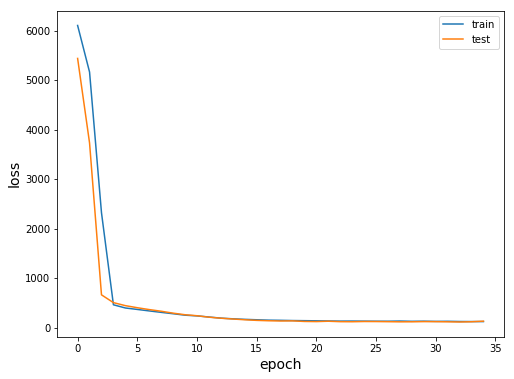

In [81]:
history, pred, acc_train, acc_test = NN([64, 32], nep=35)
# Errors
testScoreECM = mean_squared_error(Y_test, pred)
print('ECM: %.4f' % (testScoreECM))
testScoreEAM = mean_absolute_error(Y_test, pred)
print('EAM: %.4f' % (testScoreEAM))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))# 6,6
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#ax.set_yscale("log")
#plt.title('model loss')
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['train', 'test'], loc='upper right')

In [69]:
ECM = []
EAM = []
for it in range(25):
    print('Iteration ', it)
    history, pred, acc_train, acc_test = NN([64, 32], nep=35)
    ECM.append(mean_squared_error(Y_test, pred))
    EAM.append(mean_absolute_error(Y_test, pred))
print(':ECM: %.4f' % (np.mean(ECM)))
print(':EAM: %.4f' % (np.mean(EAM)))

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
:ECM: 116.3143
:EAM: 8.6692


# Plots

In [25]:
startdaypred = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA)-len(pred), unit='D')

Text(0.5,0.98,'Weekly Fitting at LSC - Hall A')

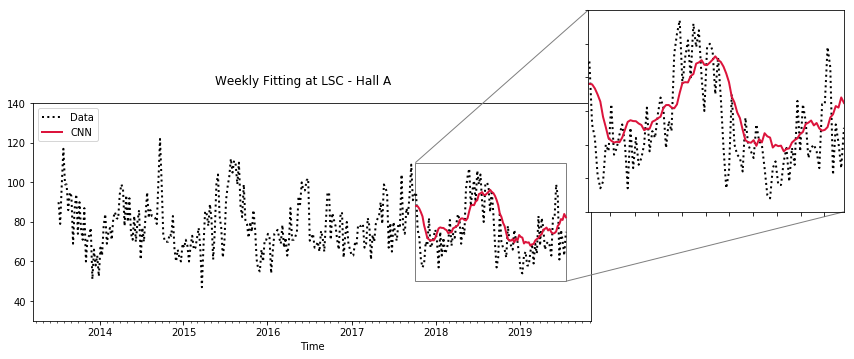

In [82]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,4))
plt.figure(1)
xaxis = ax.get_xaxis()
#ax.xaxis.grid(b=True, which='minor', color='0.90', linewidth=0.6)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

ax.plot(pd.date_range(startday, periods=len(mdnRnA), freq='W'), mdnRnA, linewidth=2, color='k', linestyle=':') 
ax.plot(pd.date_range(startdaypred, periods=len(pred), freq='W'), pred, linewidth=2, linestyle='-',color='crimson')
plt.xlabel('Time')
ax.legend(['Data', 'CNN'], loc='upper left')
plt.ylim([30, 140])

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
axins = zoomed_inset_axes(ax, 1.7, loc='lower left', bbox_to_anchor=(640,140))
axins.plot(pd.date_range(startday, periods=len(mdnRnA), freq='W'), mdnRnA, linewidth=2, color='k', linestyle=':') 
axins.plot(pd.date_range(startdaypred, periods=len(pred), freq='W'), pred, linewidth=2, linestyle='-',color='crimson')
axins.set_xlim('2017-10-05', '2019-07-21')
axins.set_ylim(50, 110)

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.suptitle('Weekly Fitting at LSC - Hall A')